In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 23 14:11:48 2023

This code extracts the rainfall from gridded rainfall data that is associated 
with the passage of a synoptic weather system, within a defined radius of 
influence. It does this by looping through a table of weather system events, and
for each system on each day it masks the field in the gridded rainfall data by
the defined radius. The output is a netcdf file of masked rainfall fields. 

@author: nick
"""
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.dates as dt
import matplotlib.pyplot as plt

In [2]:
# ============================ Define Useful Functions =======================
def day_of_studyperiod(y,m,d,y0):
    
    '''This function takes a date in y,m,d,h format and returns the value of the
    hours since jan 1, y0 (the time convention of reanalysis). Inputs are integers. 
    Output is a float.''' 
    
    d0 = datetime(y0,1,1) # the datetime object representing 12am, jan 1 of the baseline year of the reanalysis
    d = datetime(y,m,d) # the datetime object for the day and time being tested
    
    d = (dt.date2num(d) - dt.date2num(d0)) + 1 # number of days since jan 1 of 
    # the baseline year.
    # dt.date2num gives the number of days since the python datetime time origin. 
    
    return d

def mm_dd_hh(n):
    if n < 10:
        return '0'+str(n)
    else:
        return str(n)

In [91]:
# ============================= Set Key Parameters ============================
precip_data_dir = '/g/data/zv2/agcd/v1/precip/total/r005/01day/'

save_dir = '/home/561/nxg561/00_Tracking_Scheme_Comparison/Output_Data/R13vsPV/'

#input_filename = 'r13_matches'
#input_filename = 'r13_only'
input_filename = 'pv_only'
output_filename = 'precip_' + input_filename + '.nc'

#radius = 10 # degrees lat/lon from center of weather system

years = (1979, 2009)
months = (4,10)
lats = (-30, -45)
lons = (125, 155)

y = 291
x = 601

numyears = years[1] - years[0] + 1

In [92]:
# ============================= Load Rainfall Data ============================

files = [precip_data_dir + 'agcd_v1_precip_total_r005_daily_{}.nc'.format(yr) for yr in range(years[0], years[1] + 1)]

precip_ds = xr.open_mfdataset(files, combine = 'nested', concat_dim = 'time', engine = 'netcdf4')

#lat_scale = precip_ds['lat'].data
#lon_scale = precip_ds['lon'].data
#time_scale = precip_ds['time'].data

#precip_np = precip_ds['precip'].data


In [93]:
# ======================== Load and Wrangle Weather System Table ==============
# This part writes a new timestep value to the timestep column of the weather
# system array. The new timestep value refers to the day of the study period
# that the rainfall data is being extracted for. 
weather_systems_np = np.loadtxt(save_dir + input_filename + '.txt', delimiter = ',')

#print(weather_systems_np)

In [94]:
# compute and add the day of study period  number
date_list = []
num_dates = np.shape(weather_systems_np)[0]

for ii in range(num_dates):
    #datestr = pd.datetime(int(weather_systems_np[ii,0]) + '-' + mm_dd_hh(int(weather_systems_np[ii,1])) + '-' + mm_dd_hh(int(weather_systems_np[ii,2])))
    #datestr = pd.datetime(int(weather_systems_np[ii,0]), int(weather_systems_np[ii,1]), int(weather_systems_np[ii,2]))
    datestr = str(int(weather_systems_np[ii,0])) + '-' + mm_dd_hh(int(weather_systems_np[ii,1])) + '-' +  mm_dd_hh(int(weather_systems_np[ii,2]))
    date_list.append(datestr)


In [95]:
# Finally extract the precip data associated with the weather systems
precip_array = np.zeros((len(date_list), y, x))

for ii in range(len(date_list)):

    #print(date_list[ii])
    precip_ds_subset = precip_ds['precip'].sel(lat=slice(lats[1], lats[0]), lon=slice(lons[0], lons[1]), time=date_list[ii]) #date_list[-1])
    precip_array[ii,:,:] = precip_ds_subset.data

In [96]:
#
# HOW ABOUT JUST COMPUTE THE COMPOSITE SUM OF precip_ds_masked AND THEN SAVE THAT?
#
# precip_ds_composite = precip_ds_masked.sum(dim = 'time') / numyears
# Save the output as a netcdf file
# precip_ds_composite.to_netcdf(save_dir + output_filename ,mode = 'w') 
mean_precip = precip_array.sum(axis = 0) / numyears
np.shape(mean_precip)

(291, 601)

In [97]:
# This part creates lat and lon vectors to go with the precip numpy array, so the array can be 
# converted to an xarray object and saved as a netcdf. 
lat_vector = precip_ds['lat'].sel(lat=slice(lats[1], lats[0])).data
lon_vector = precip_ds['lon'].sel(lon=slice(lons[0], lons[1])).data

ds_out = xr.Dataset(data_vars={'precip':(('lat', 'lon'), mean_precip)}, coords={'lat': lat_vector,'lon': lon_vector})
ds_out.to_netcdf(save_dir + output_filename)
#data_xr = xr.DataArray(mean_precip, coords={'lat': lat_vector,'lon': lon_vector}, dims=["lat", "lon"])
#data_xr.to_netcdf(save_dir + output_filename)

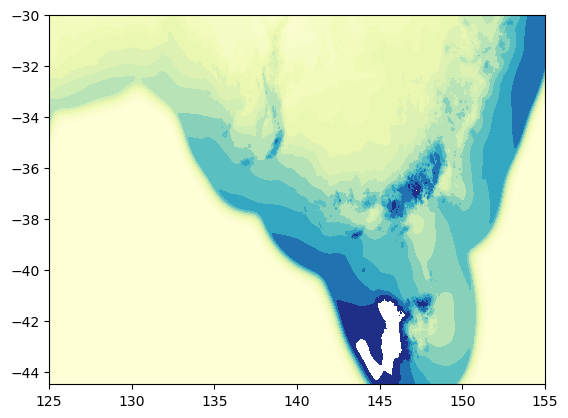

In [98]:
scale_levels = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 125, 150, 200, 250]
precip_layer = plt.contourf(lon_vector, lat_vector, mean_precip, levels = scale_levels, cmap = plt.cm.YlGnBu)
plt.show()

In [90]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 291, lon: 601)
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -30.1 -30.05 -30.0
  * lon      (lon) float32 125.0 125.1 125.1 125.2 ... 154.9 154.9 154.9 155.0
Data variables:
    precip   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 448.7 452.0 455.1 458.2